# Similarity
This section of the project aims to identify a method for finding rows in a given data frame that are similar to the input data. The objective is to create a visualization that demonstrates how patients responded to similar internal and external factors and determine the required insulin dose to achieve normal after-meal glucose levels.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

### Style configuration

In [2]:
#Colors
background = '#F0F0F0'
red = '#ED462F'
pink = '#F1BBB8'
green = '#4CB866'
blue = '#003D83'
black = '#333333'
grey = '#C6D0D2'

#Matplotlib configurations

plt.rcParams.update({'axes.facecolor' : grey,
                     'axes.edgecolor': background,   
                     'axes.linewidth': 2,
                     'figure.facecolor' : grey,
                     'font.family' : 'monospace',
                     'xtick.color' : background,
                     'ytick.color' : background,
                     'xtick.labelcolor' : '#8C9496',
                     'ytick.labelcolor' : '#8C9496',
                     'legend.labelcolor' : '#8C9496'
                     })




### Preparing data
#### Read data

In [3]:
# Read data in csv format
df = pd.read_csv('/Users/polzovatel/Desktop/Python/Portfolio/Diabetes_3/1_2_Preprocessing/FullData_preprocessed.csv')
df

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
0,2022-12-09 07:00:00,B-L,1.756,4.7,4.7,3.0,3.5,1820,-16,74
1,2022-12-09 18:00:00,D-B,3.442,4.3,6.5,2.0,4.0,18,-12,69
2,2022-12-10 07:00:00,B-L,1.584,6.5,5.6,3.0,4.0,2607,-13,77
3,2022-12-10 12:00:00,L-D,2.562,5.6,6.2,2.5,2.0,2067,-12,66
4,2022-12-10 18:00:00,D-B,4.190,6.2,6.1,2.0,3.5,487,-12,66
...,...,...,...,...,...,...,...,...,...,...
198,2023-02-24 12:00:00,L-D,2.194,6.5,6.2,3.0,3.0,1715,-10,66
199,2023-02-24 18:00:00,D-B,2.389,6.2,5.1,3.0,2.5,0,-9,66
200,2023-02-25 07:00:00,B-L,1.706,5.1,6.7,3.0,3.0,1505,-15,65
201,2023-02-25 12:00:00,L-D,1.952,6.7,3.8,3.0,3.0,68,-11,56


#### Filter data

In [4]:
# Retrieve only the rows where the post-meal blood glucose level falls within the normal range.
df_norm_BG2 = df[(df['BG2']>3.9)&(df['BG2']<5.5)].reset_index(drop=True)
df_norm_BG2

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
0,2022-12-09 07:00:00,B-L,1.756,4.7,4.7,3.0,3.5,1820,-16,74
1,2022-12-11 18:00:00,D-B,2.639,7.1,4.2,2.0,3.5,20,-13,63
2,2022-12-12 07:00:00,B-L,1.763,4.2,5.1,3.0,3.5,2430,-19,79
3,2022-12-12 18:00:00,D-B,2.740,6.6,5.3,2.0,3.5,12,-11,56
4,2022-12-13 07:00:00,B-L,1.834,5.3,4.8,3.0,3.5,2392,-14,81
...,...,...,...,...,...,...,...,...,...,...
108,2023-02-22 12:00:00,L-D,2.105,4.3,4.3,3.0,2.5,5812,-10,48
109,2023-02-23 07:00:00,B-L,1.872,3.8,4.4,3.0,3.0,2249,-16,72
110,2023-02-23 18:00:00,D-B,2.376,5.9,4.6,3.0,2.5,20,-6,61
111,2023-02-24 18:00:00,D-B,2.389,6.2,5.1,3.0,2.5,0,-9,66


#### Create data for analysis and  the input data

In [5]:
# Assign a variable to the filtered data frame
data = df_norm_BG2.copy()
data

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
0,2022-12-09 07:00:00,B-L,1.756,4.7,4.7,3.0,3.5,1820,-16,74
1,2022-12-11 18:00:00,D-B,2.639,7.1,4.2,2.0,3.5,20,-13,63
2,2022-12-12 07:00:00,B-L,1.763,4.2,5.1,3.0,3.5,2430,-19,79
3,2022-12-12 18:00:00,D-B,2.740,6.6,5.3,2.0,3.5,12,-11,56
4,2022-12-13 07:00:00,B-L,1.834,5.3,4.8,3.0,3.5,2392,-14,81
...,...,...,...,...,...,...,...,...,...,...
108,2023-02-22 12:00:00,L-D,2.105,4.3,4.3,3.0,2.5,5812,-10,48
109,2023-02-23 07:00:00,B-L,1.872,3.8,4.4,3.0,3.0,2249,-16,72
110,2023-02-23 18:00:00,D-B,2.376,5.9,4.6,3.0,2.5,20,-6,61
111,2023-02-24 18:00:00,D-B,2.389,6.2,5.1,3.0,2.5,0,-9,66


In [6]:
# Create an input row
input_row = pd.DataFrame({'Interval':'B-L','DV':1.8,'BG1':5,'SC':2000,'Temp':-17,'Humid':70},index=[0])
input_row 

,Interval,DV,BG1,SC,Temp,Humid
0,B-L,1.8,5,2000,-17,70


### Find similar rows

In [7]:
# A function that finds similar rows based on cosine similarity
# Takes in the data, the input_row and a number of similar rows
# Returns similar rows indices
def find_similar_rows(data, input_row, num_similar_rows):
    
    # concatenate
    data_with_input = pd.concat([data[['Interval','DV','BG1','SC','Temp','Humid']],
                                 input_row]).reset_index(drop=True)
    
    # get dummies
    data_wd = pd.get_dummies(data_with_input)
    
    # calculate the cosine similarity between the input row and each row in the dataset
    similarity_scores = cosine_similarity(data_wd.iloc[:-1], data_wd.iloc[[-1]]).flatten()
    
    ranked_indices = np.argsort(similarity_scores)[::-1][:num_similar_rows]

    return ranked_indices

In [15]:
similar_rows_indices = find_similar_rows(data, input_row, num_similar_rows=4)
similar_rows_indices

array([107,   2,   4,  74])

In [16]:
df_norm_BG2.loc[similar_rows_indices]

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
107,2023-02-22 07:00:00,B-L,1.706,4.9,4.3,3.0,3.0,1834,-16,67
2,2022-12-12 07:00:00,B-L,1.763,4.2,5.1,3.0,3.5,2430,-19,79
4,2022-12-13 07:00:00,B-L,1.834,5.3,4.8,3.0,3.5,2392,-14,81
74,2023-02-06 07:00:00,B-L,1.734,6.4,4.8,3.0,4.0,1996,-18,64


### Plot similar rows

In [17]:
# Define a data frame to plot
plot_df = pd.concat([df_norm_BG2.drop(['Date','Interval','bID'],axis=1),
                     input_row.drop('Interval',axis=1)]).reset_index(drop=True)
plot_df

,DV,BG1,BG2,shID,SC,Temp,Humid
0,1.756,4.7,4.7,3.5,1820,-16,74
1,2.639,7.1,4.2,3.5,20,-13,63
2,1.763,4.2,5.1,3.5,2430,-19,79
3,2.740,6.6,5.3,3.5,12,-11,56
4,1.834,5.3,4.8,3.5,2392,-14,81
...,...,...,...,...,...,...,...
109,1.872,3.8,4.4,3.0,2249,-16,72
110,2.376,5.9,4.6,2.5,20,-6,61
111,2.389,6.2,5.1,2.5,0,-9,66
112,2.677,3.8,4.3,2.5,67,-7,59


In [18]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

In [19]:
# Scale the plot_df
scaled_data = scaler.fit_transform(plot_df)
scaled_plot_df = pd.DataFrame(scaled_data,columns=plot_df.columns)
scaled_plot_df = scaled_plot_df[['DV','BG1','SC','Temp','Humid','shID','BG2']]
scaled_plot_df

,DV,BG1,SC,Temp,Humid,shID,BG2
0,0.091754,0.333333,0.313145,0.538462,0.685185,0.375,0.500000
1,0.448666,0.904762,0.003441,0.653846,0.481481,0.375,0.142857
2,0.094584,0.214286,0.418100,0.423077,0.777778,0.375,0.785714
3,0.489491,0.785714,0.002065,0.730769,0.351852,0.375,0.928571
4,0.123282,0.476190,0.411562,0.615385,0.814815,0.375,0.571429
...,...,...,...,...,...,...,...
109,0.138642,0.119048,0.386958,0.538462,0.648148,0.250,0.285714
110,0.342361,0.619048,0.003441,0.923077,0.444444,0.125,0.428571
111,0.347615,0.690476,0.000000,0.807692,0.537037,0.125,0.785714
112,0.464026,0.119048,0.011528,0.884615,0.407407,0.125,0.214286


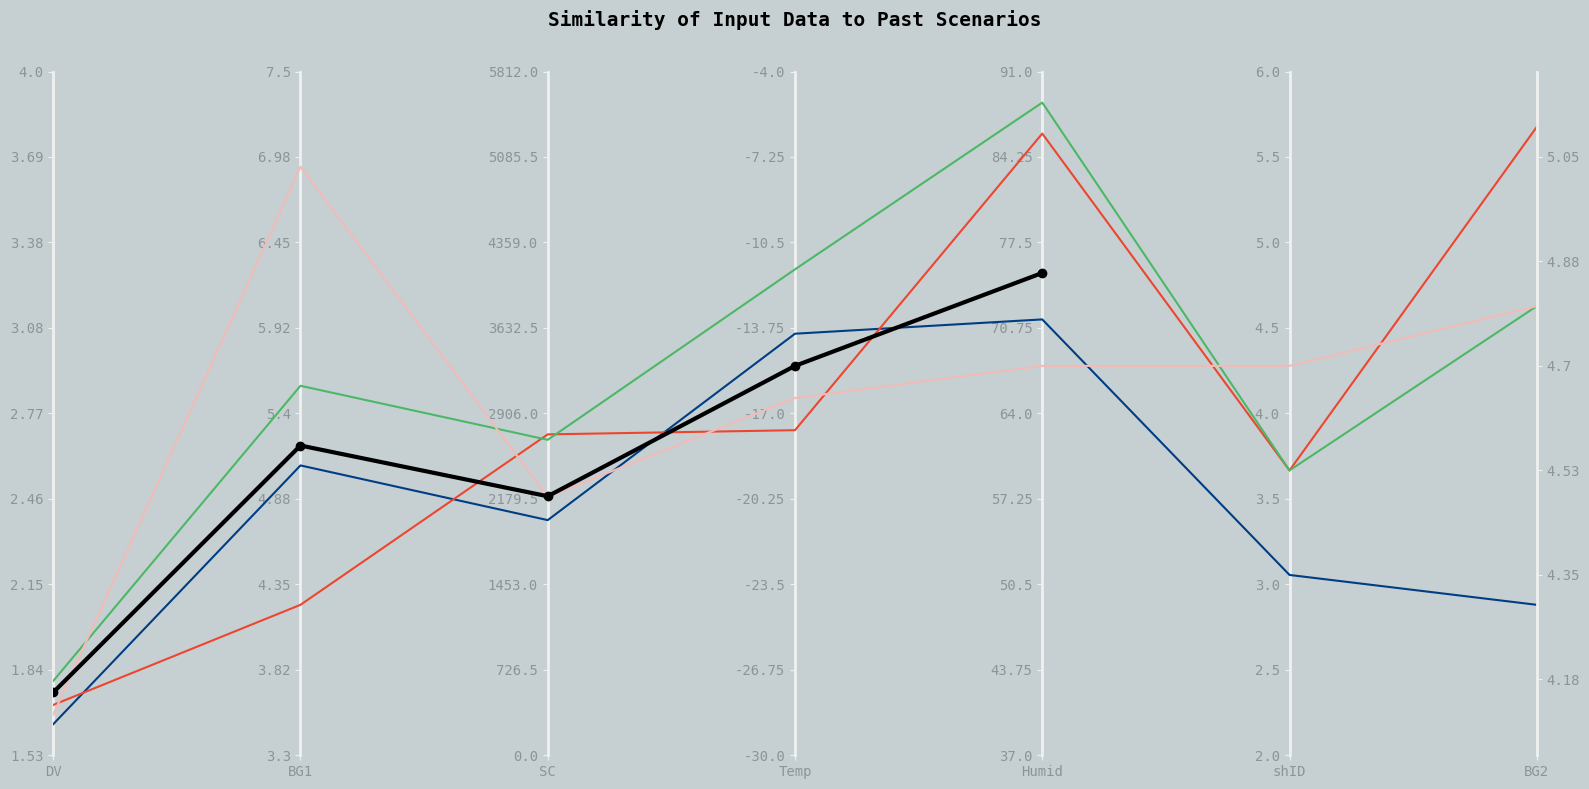

In [25]:
# Plot similar rows
## Create a figure and axes
fig,ax = plt.subplots(figsize=(16,8))
fig.suptitle('Similarity of Input Data to Past Scenarios\n',fontsize=14,fontweight='bold')

## Configure the axes
ax.set_ylim(0,1)
ax.set_xlim(0,6)
ax.spines[['top','bottom','right']].set_visible(False)

## Prepare scaled data
similar_rows_plot_df = scaled_plot_df.iloc[similar_rows_indices]
input_row_plot_df = scaled_plot_df.iloc[-1]

## Create custom y tick labels
custom_ytick_labels = []
for c in scaled_plot_df.columns:
    custom_ytick_labels.append(np.round(np.linspace(plot_df[c].min(),plot_df[c].max(),9),2))  

## Create y ticks
yticks = np.linspace(0,1,9)

## Set x and y ticks and tick labels on the first axis
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(scaled_plot_df.columns)
ax.set_yticks(yticks)
ax.set_yticklabels(custom_ytick_labels[0])

## Create twin axes and set ticks and tick labels
for i in range(1,7):
    ax = plt.twinx()
    ax.spines["left"].set_position(("axes", i/6)) 
    ax.set_yticks(yticks)
    ax.set_yticklabels(custom_ytick_labels[i])
    ax.spines[['top','bottom','right']].set_visible(False)

## Plot scaled data
colors = [blue,red,green,pink]
for i in range(len(similar_rows_plot_df)):
    ax.plot(range(0,7),similar_rows_plot_df.iloc[i],color=colors[i])

ax.plot(range(0,7),input_row_plot_df,color='black',lw=3,marker='o')

    
plt.tight_layout();

### Calculate shID traditional way

In [21]:
# Calculate shID using traditional formula assuming that:
    # target BG = 4.7, 1 unit of insulin will reduce BG by 2.8 mmol/l and cover 1 bread units (10g of carbs)
shID = (input_row['BG1'].values-4.7)/2.8 + input_row['DV'].values/1
shID

array([1.90714286])

### Results

Based on the visualization above, it is evident that the input data align most closely with the blue line on the graph. This alignment corresponds to a required shID value of 3.0 to achieve a BG2 level of approximately 4.3. Although this value is lower than the target BG2 4.7, it still falls within the normal range. In contrast, when using the traditional formula, the expected shID value is 1.9, which is noticeably lower. Such a low shID value may lead to higher after-meal glucose levels, indicating the limitations of the traditional formula in this particular situation.

### Conclusion

In summary, the application of cosine similarity has proven to be an efficient method for identifying similar rows to the input data, which enabled effective data visualization.